# Initializing and Preprocessing
Load up experiment & annotations

In [1]:
import sys
sys.path.append("//tmp/pycharm_project_688/")
sys.path.append("//tmp/pycharm_project_688/src/")

import pandas as pd
from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction, \
    preprocess_chunks_for_null_test_with_indoor
from preprocessing._segmentation import segment_null_classification, segment_windows
from visualization._visualization import swarm_plot_top_features

%load_ext autoreload
%autoreload 2

from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from visualization import plot_duration_histogram
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters

In [2]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
sample_rate = 50
feature_calculation_setting = MinimalFCParameters

# complete_experiments_indices = [1,2,3,5,7]
# experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]


FileNotFoundError: [Errno 2] No such file or directory: '../../data/phyphox/full recordings/'

Preprocess data

In [11]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)


NameError: name 'experiment_dirs' is not defined

In [25]:
y


,start,end,label,hand
0,11.800,13.600,pushing door,right
1,16.105,19.305,pulling door,right
2,20.700,23.100,pushing door,right
3,26.005,28.605,pulling door,right
4,31.300,34.200,pushing door,right
...,...,...,...,...
77,1222.000,1226.300,cleaning table,right
78,1228.700,1234.700,cleaning table,right
79,1236.400,1241.900,cleaning table,right
80,1243.500,1249.300,cleaning table,right


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mean 7.57 +/- 11.83
Mean 7.68 +/- 22.98


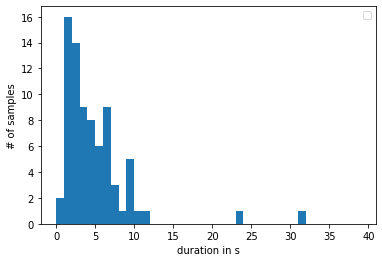

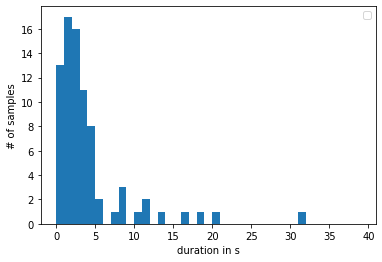

In [20]:
plot_duration_histogram(chunks["right"])
plot_duration_histogram(null_chunks["right"])

# append the action id to the dataframe
# we need to do this to be able to extract time series features later
# Preprocess data


if use_indoor:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test_with_indoor(chunks, null_chunks)
else:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)

### Segmentation

In [21]:
labels = y.loc[:, "label"].squeeze()


# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

/tmp/pycharm_project_258/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


## Binary Classification: OCD activities vs null class samples
### Feature extraction for OCD activities vs non-OCD activities

In [23]:

X_null_class_classification = extract_timeseries_features(null_classification_df, True, feature_set_config=feature_calculation_setting)

TypeError: extract_timeseries_features() takes 2 positional arguments but 3 were given

### Feature selection

In [ ]:

impute(X_null_class_classification)
X_null_classification_selected = select_features(X_null_class_classification, labels_null_classification)

In [ ]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [21]:
labels_null_classification.values

array([12, 12, 12, ..., 11, 11, 11])

### Train models and score results

In [10]:
print("Binary classification")
classify_all(X_null_classification, labels_null_classification)

Two handed classification
Logistic Regression: 0.53 +/- 0.08
LDA: 0.50 +/- 0.05
LinearSVC: 0.52 +/- 0.07
CART: 0.50 +/- 0.06
Random Forest: 0.53 +/- 0.14
NB: 0.51 +/- 0.12


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

In [51]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

(1, 0)      12
(1, 1)      12
(2, 0)      12
(3, 0)      12
(3, 1)      12
            ..
(380, 2)    11
(382, 0)    11
(383, 0)    11
(383, 1)    11
(384, 0)    11
Length: 1319, dtype: int64

   index         class                                           features  \
0      0  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
1      1  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
2      2  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
3      3  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   
4      4  OCD activity  acceleration x__fft_coefficient__attr_"angle"_...   

      value  
0 -0.781345  
1 -0.781345  
2 -0.781345  
3 -0.781345  
4 -0.781345  


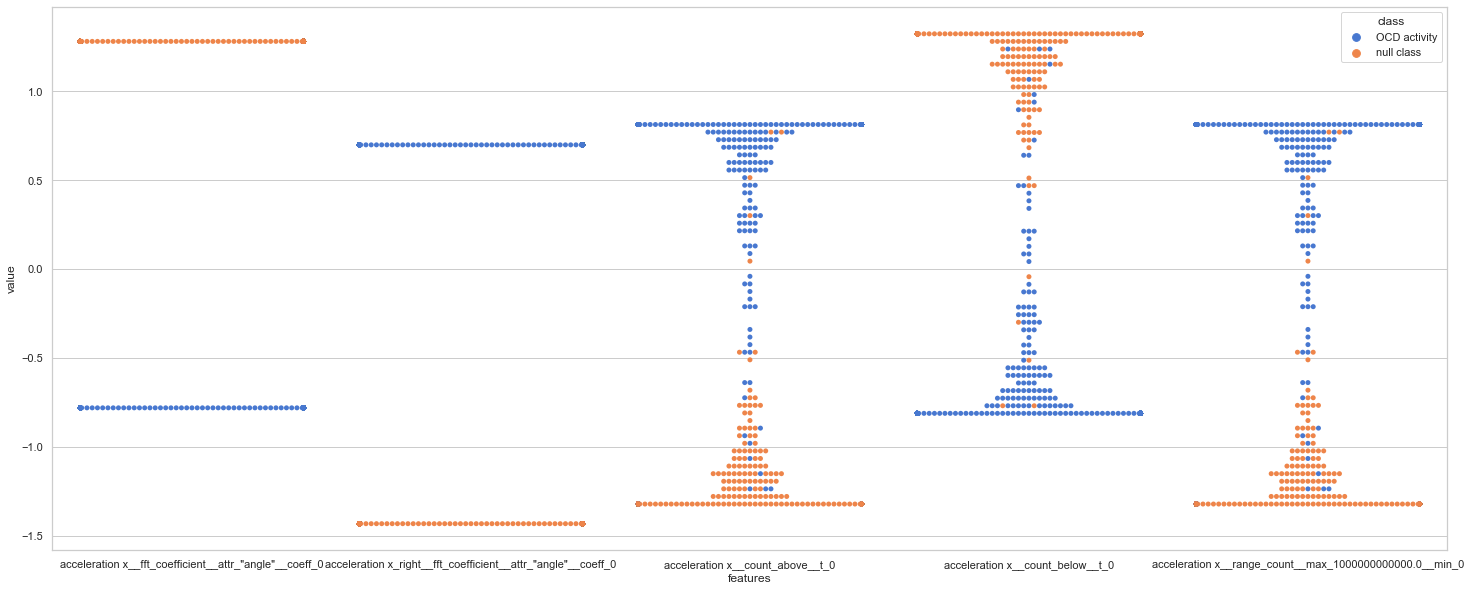

In [69]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_null_classification_selected.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())


# Multiclass classification

For the multi class classification we can reuse
- data loading
- preprocessing
- segmentation

We mainly need to:
- re label the OCD segments with the y array
- do the segmentation for the ocd chunks again
- extract features again
- select and scale features again
- classify again
- visualize results again

In [5]:
# make sure we already run the segmentation for the binary classification earlier

assert len(labels_null_segmented) != 0

labels_ocd_multiclass = labels.reset_index(drop=True)
_, labels_ocd_segmented_multiclass = segment_windows(chunks_ocd, labels_ocd_multiclass.to_numpy(), window_size)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

In [6]:
# reuse chunks_ocd_segmented from the segmentation for the binary classifier
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

In [7]:
labels_multi_class_classification

(1, 0)      pushing door
(1, 1)      pushing door
(2, 0)      pulling door
(3, 0)      pushing door
(3, 1)      pushing door
                ...     
(380, 2)      null class
(382, 0)      null class
(383, 0)      null class
(383, 1)      null class
(384, 0)      null class
Length: 1319, dtype: object

### Feature extraction for OCD activities vs non-OCD activities

In [ ]:
X_multi_class_classification = extract_timeseries_features(mulit_class_df, True)

In [ ]:
X_multi_class_classification.head()

### Feature selection for multi class OCD activities incl null

In [ ]:
impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)


In [ ]:
scaler = StandardScaler()
X_multi_class_classification = scaler.fit_transform(X_multi_class_classification_selected)

### Train models and score results

In [ ]:
print("Multi class classification with null class")
classify_all(X_multi_class_classification, labels_multi_class_classification)
